In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import iirnotch, butter, filtfilt

class BandFilter:
    def __init__(self, order=4, fc_bp=[20, 480], freq=1000):
        nyq = 0.5 * freq
        low = fc_bp[0] / nyq
        high = fc_bp[1] / nyq
        self.b, self.a = butter(order, (low, high), btype = 'bandpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x
    
class LowPassFilter:
    def __init__(self, order=2, fc_bp=4, freq=1000):
        nyq = 0.5 * freq
        low = fc_bp / nyq
        self.b, self.a = butter(order, low, btype = 'lowpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

class HighPassFilter:
    def __init__(self, order=2, fc_bp=30, freq=1000):
        nyq = 0.5 * freq
        high = fc_bp / nyq
        self.b, self.a = butter(order, high, btype = 'highpass', output='ba')
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

class NotchFilter:
    def __init__(self, f0=60, freq=1000):
        f0 = f0  # Frequency to be removed from signal (Hz)
        Q = 30.0  # Quality factor
        self.b, self.a = iirnotch(f0, Q, freq)
    
    def filtfilt(self, x):
        filtered_x = filtfilt(self.b, self.a, x)
        return filtered_x

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val == min_val:
        return data
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def calculate_snr(emg_data, standing_period, walking_period):
    """
    計算EMG數據的信噪比 (SNR)，根據用戶設定的站立期和行走期。
    
    :param emg_data: EMG數據數組 (1D array)
    :param standing_period: 站立期的索引範圍，tuple形式 (start_index, end_index)
    :param walking_period: 行走期的索引範圍，tuple形式 (start_index, end_index)
    
    :return: SNR值 (以dB表示)
    """
    # 提取站立期和行走期的數據
    standing_data = emg_data[standing_period[0]:standing_period[1]]
    walking_data = emg_data[walking_period[0]:walking_period[1]]
    
    # 計算站立期的噪聲功率（作為噪聲）
    noise_power = np.mean(standing_data ** 2)
    
    # 計算行走期的信號功率（作為信號）
    signal_power = np.mean(walking_data ** 2)
    
    # 防止出現除以0的情況
    if noise_power == 0:
        return float('inf')  # 無限大的信噪比，表示無噪聲
    else:
        # 計算SNR
        snr = 10 * np.log10(signal_power / noise_power)
        return snr

In [2]:
sampling_rate = 1000
h_filter = HighPassFilter(order=4, fc_bp=30)
l_filter = LowPassFilter(order=4, fc_bp=4)
n_filter = NotchFilter(f0=60)

def EMGprocessor(signal):
    filted_emg = h_filter.filtfilt(signal)
    filted_emg = n_filter.filtfilt(filted_emg)
    rect_emg = np.abs(filted_emg)
    envelope = l_filter.filtfilt(rect_emg)
    return envelope

In [3]:
emg_data = loadmat('./data/AB_UH_07T09emg.mat')
left_emg = emg_data['emg'][0,0][0]

t = np.arange(left_emg.shape[1]) / sampling_rate

data1 = np.zeros((12,152666) ,dtype=float)

for i in range(6):
    data1[i] = EMGprocessor(emg_data['emg'][0,0][0][i, ...])
for i in range(6):
    data1[i+6] = EMGprocessor(emg_data['emg'][0,0][1][i, ...])
    
data1[data1 < 0] = 0

for i in range(12):
    data1[i] = normalize_data(data1[i])

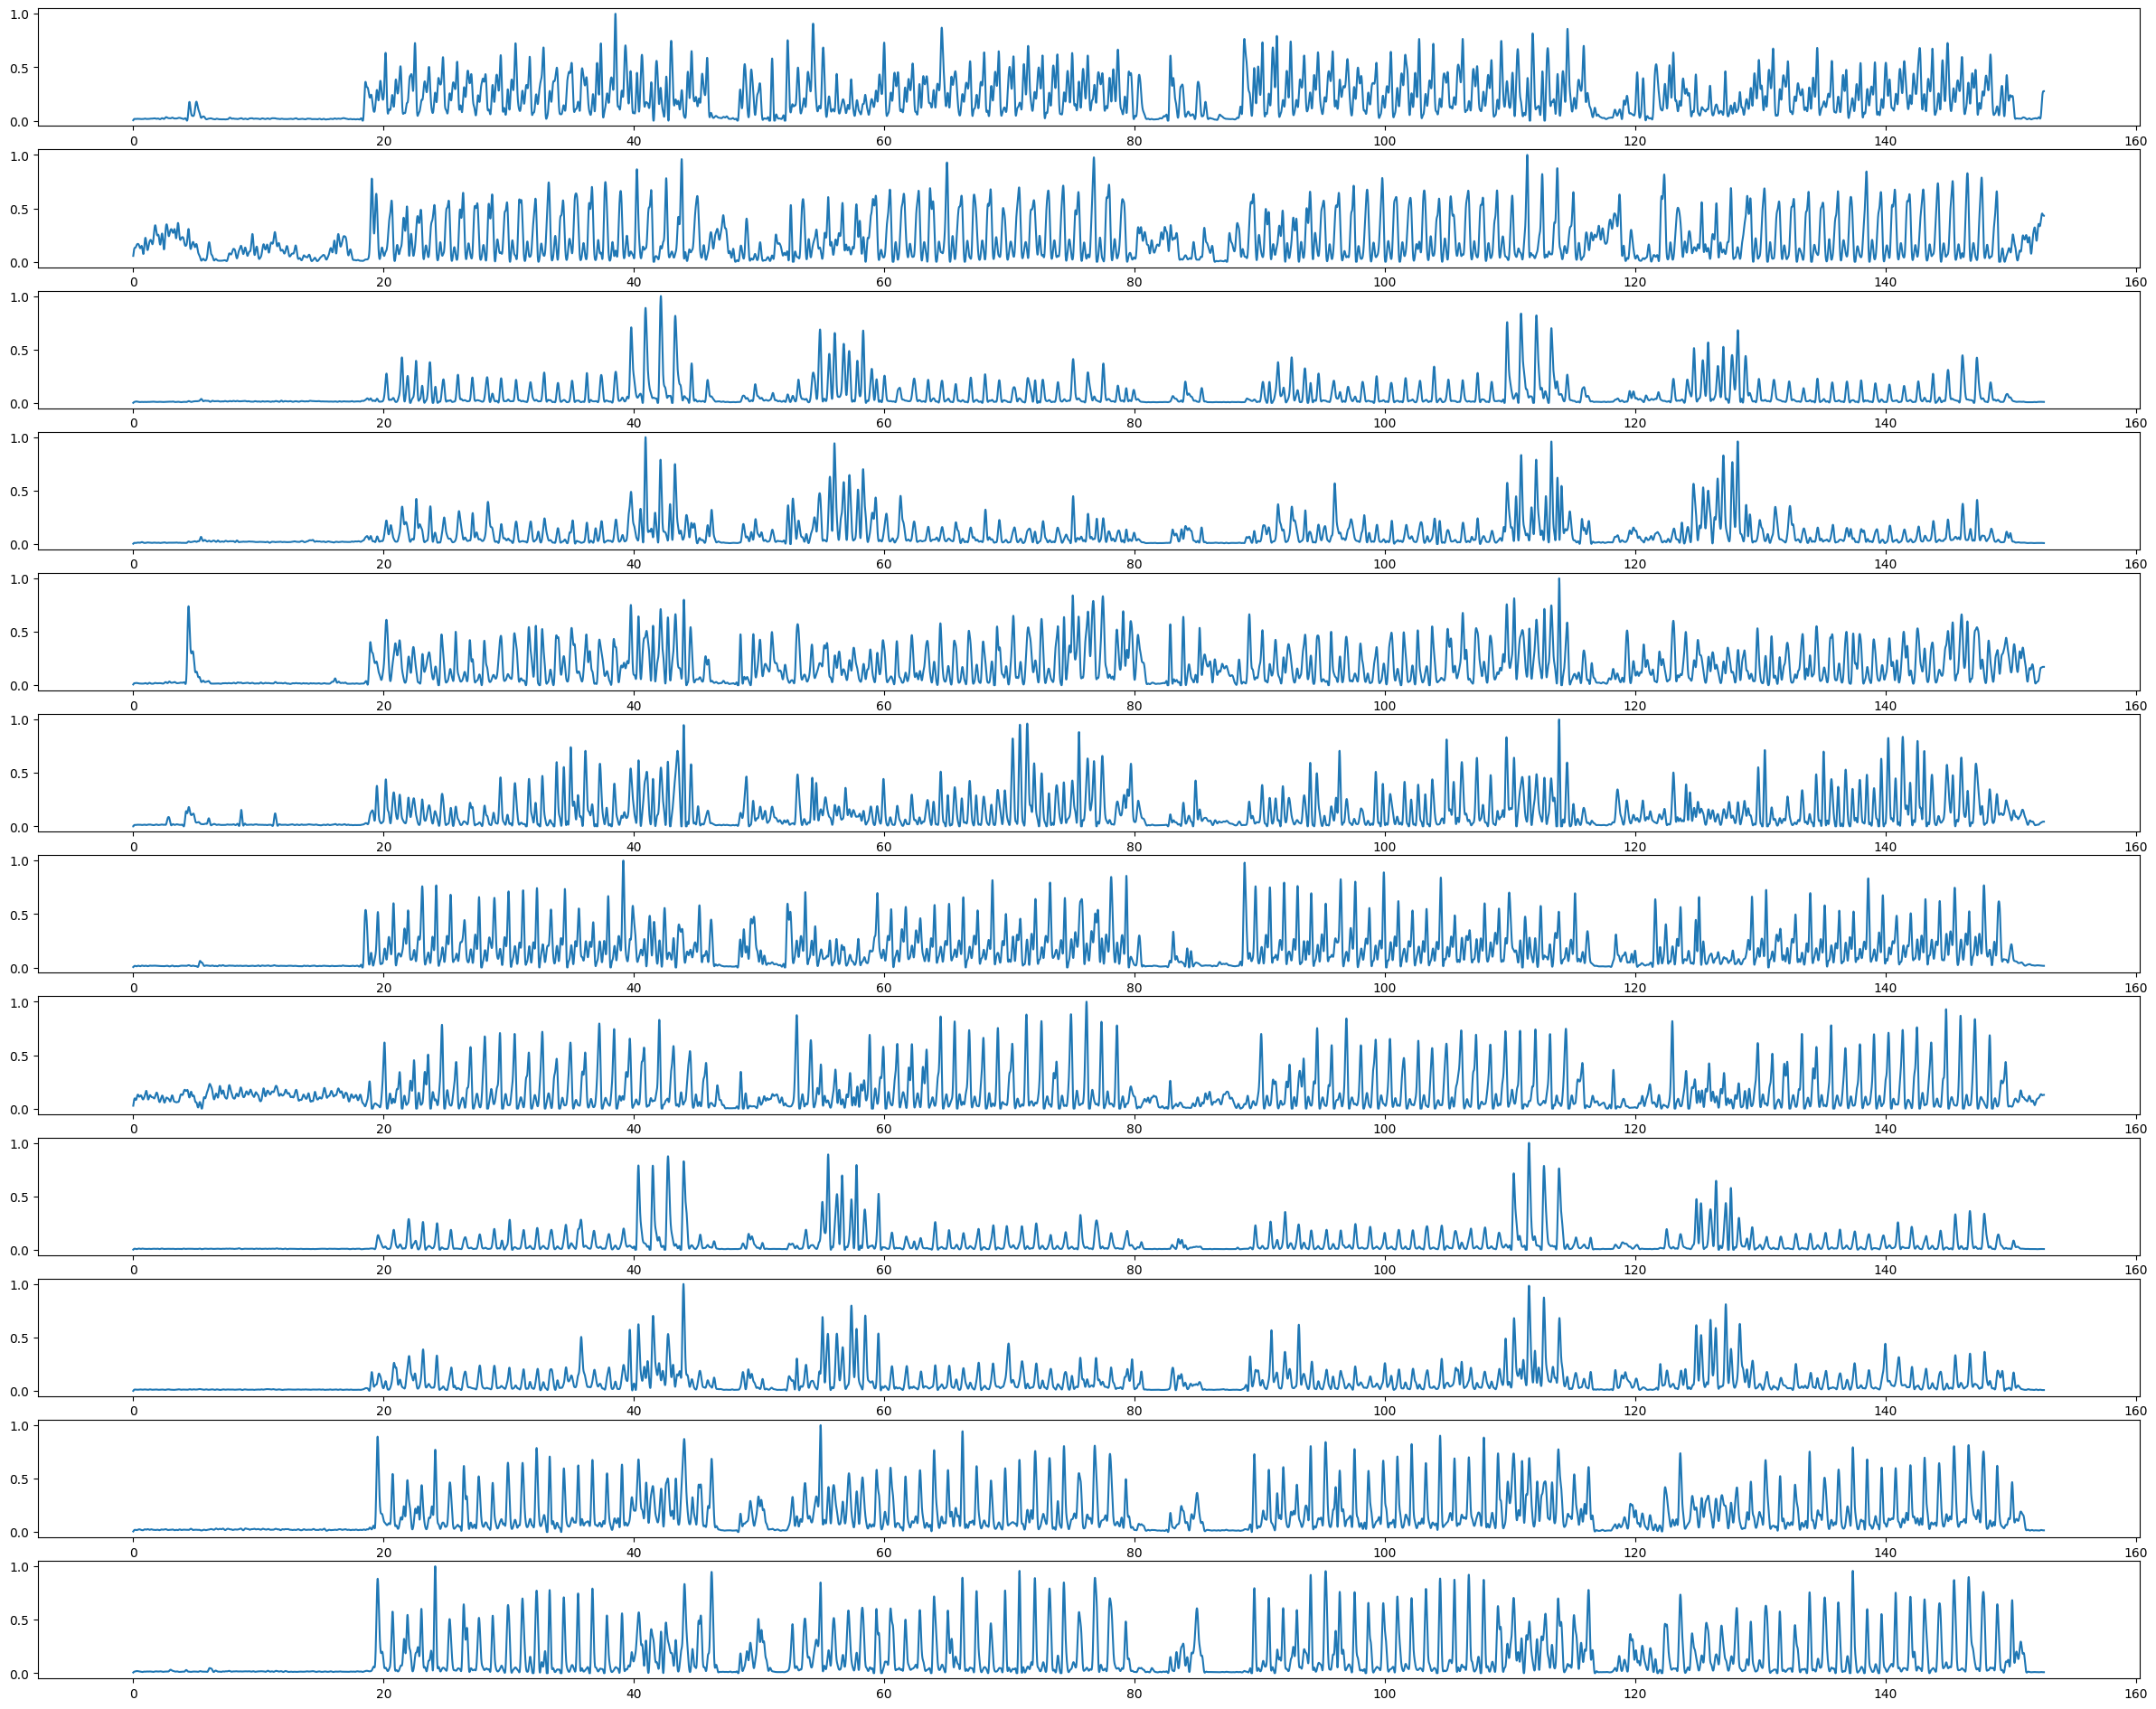

In [4]:
plt.rcParams["figure.figsize"] = (30,24)
fig,(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10, fig11, fig12) = plt.subplots(12,1)
fig1.plot(t, data1[0])
fig2.plot(t, data1[1])
fig3.plot(t, data1[2])
fig4.plot(t, data1[3])
fig5.plot(t, data1[4])
fig6.plot(t, data1[5])
fig7.plot(t, data1[6])
fig8.plot(t, data1[7])
fig9.plot(t, data1[8])
fig10.plot(t, data1[9])
fig11.plot(t, data1[10])
fig12.plot(t, data1[11])

# for i in range(12):
#     plt.plot(t, data1[i])
#     plt.xlim(0, 50)

In [5]:
standing_period = (5,15)
walking_period = (20,40)
for i in range(12):
    snr = calculate_snr(data1[i], standing_period, walking_period)
    print(snr)

4.30738502337433
2.334654835696233
6.7666095385748015
3.9769358836922946
3.033686396652619
24.074908629657283
3.4450475391864632
3.4443687170384054
5.311556059226179
8.692673683334423
3.5336178730002348
2.420856560069366


In [6]:
import pandas as pd
test = pd.read_csv('data/emg_path1_02_161328-S.csv')
test = test.iloc[:, 2:10]
test = test.transpose()
test = test.to_numpy()

# emg_path1_03_162659-S.csv_36799, 

data2 = np.zeros((8,test.shape[1]) ,dtype=float)

for i in range(8):
    data2[i] = EMGprocessor(test[i, ...])
    
data2[data2 < 0] = 0

for i in range(8):
    data2[i] = normalize_data(data2[i])


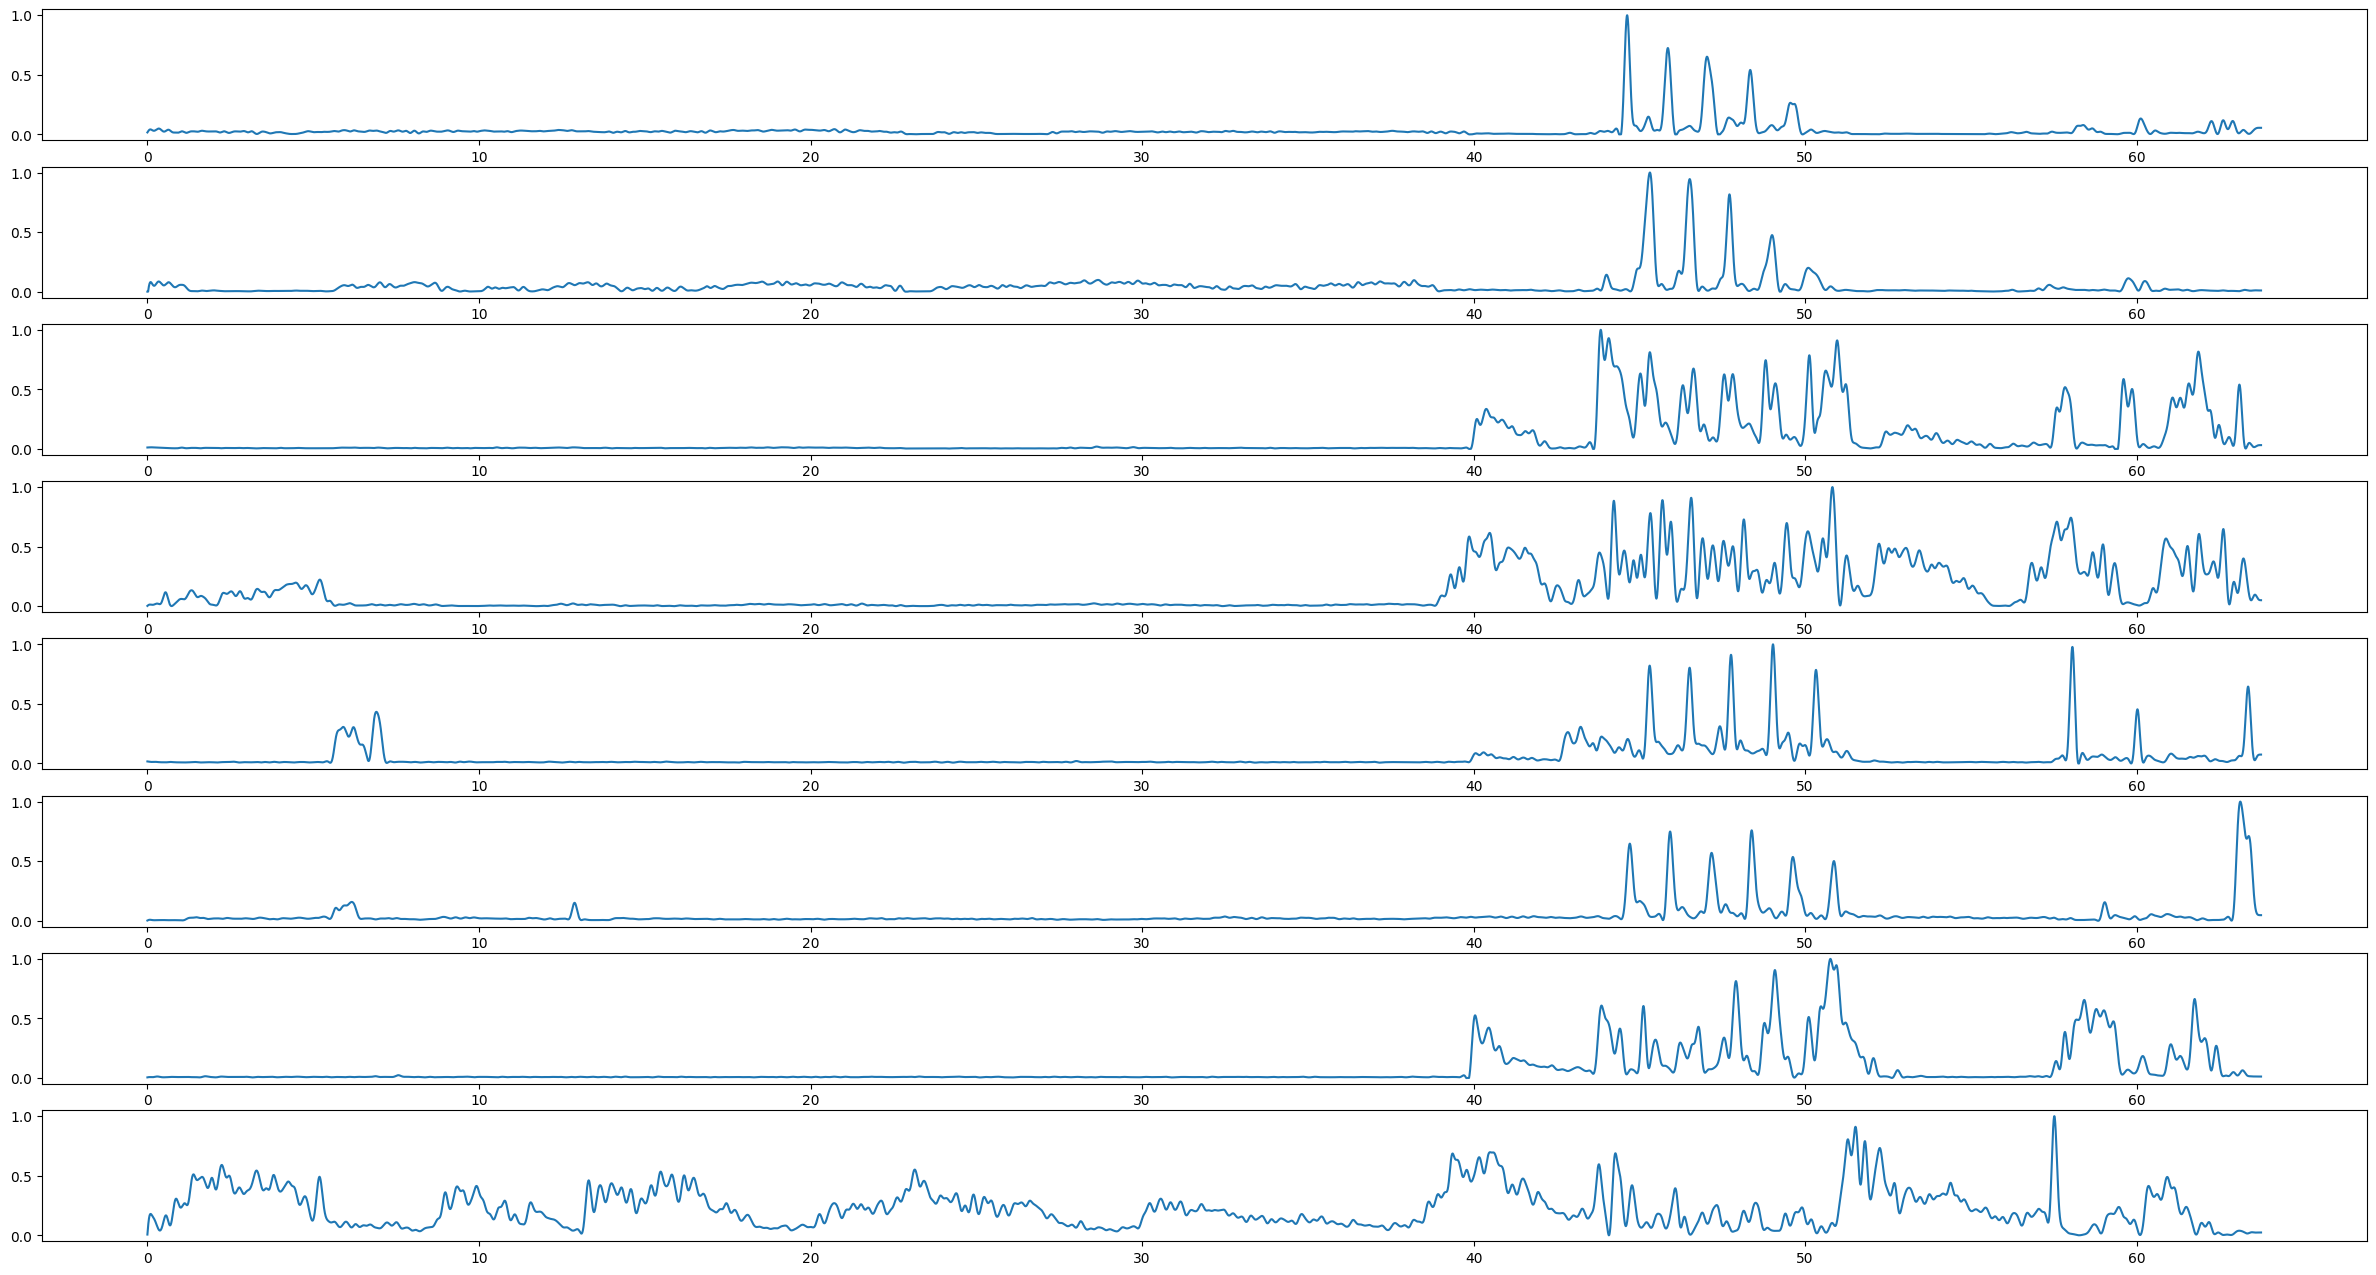

In [9]:
t2 = np.arange(test.shape[1]) / sampling_rate
plt.rcParams["figure.figsize"] = (30,16)
fig,(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8) = plt.subplots(8,1)
fig1.plot(t2, data2[0])
fig2.plot(t2, data2[1])
fig3.plot(t2, data2[2])
fig4.plot(t2, data2[3])
fig5.plot(t2, data2[4])
fig6.plot(t2, data2[5])
fig7.plot(t2, data2[6])
fig8.plot(t2, data2[7])
# plt.xlim(40, 55)

# for i in range(8):
#     plt.plot(t2, data2[i])
#     plt.xlim(40, 55)

In [8]:
standing_period = (5,20)
walking_period = (45,50)
for i in range(8):
    snr = calculate_snr(data2[i], standing_period, walking_period)
    print(snr)

4.1344372472622775
inf
0.40046696464346637
6.406094262647231
-0.7785714961163985
5.862624849875883
1.8743434176019624
8.889994858853928


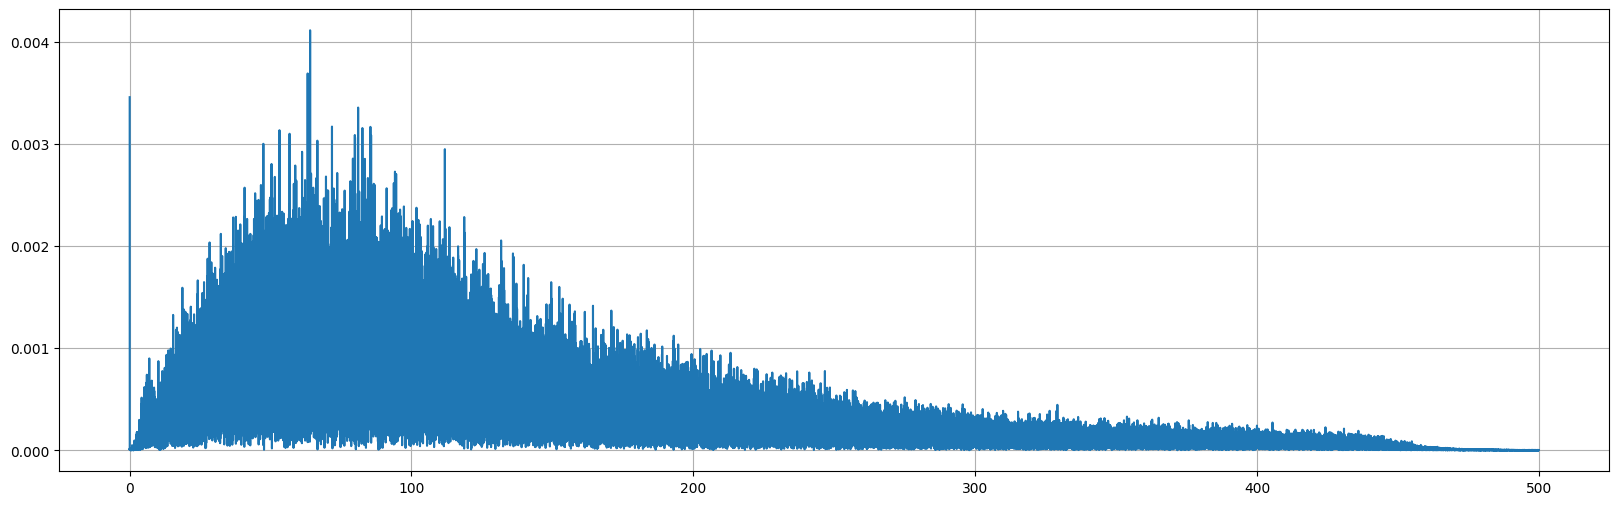

In [11]:
from scipy.fft import fft, fftfreq, ifft
plt.rcParams["figure.figsize"] = (20,6)
# Number of sample points
N = len(left_emg[0,...])
# sample spacing
T = 1.0 / sampling_rate
x = np.linspace(0.0, N*T, N, endpoint=False)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = left_emg[0, ...]
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

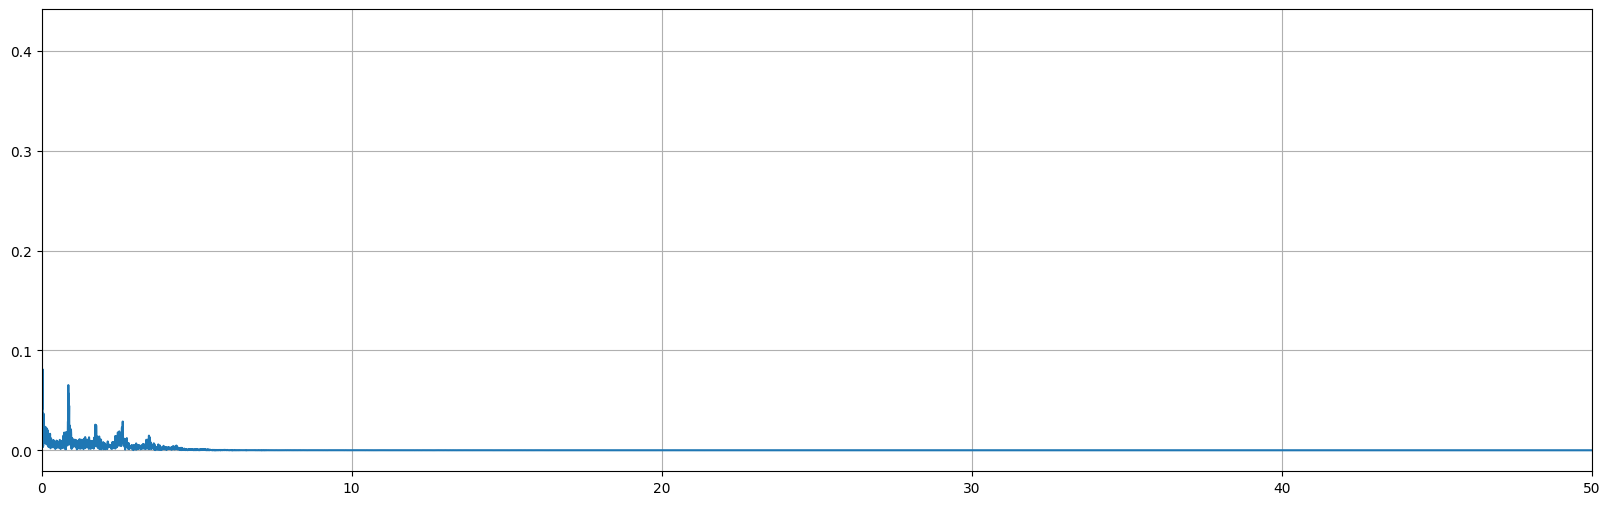

In [24]:
N = len(data1[0,...])
T = 1.0 / sampling_rate
yf = fft(data1[0])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 50)
plt.grid()

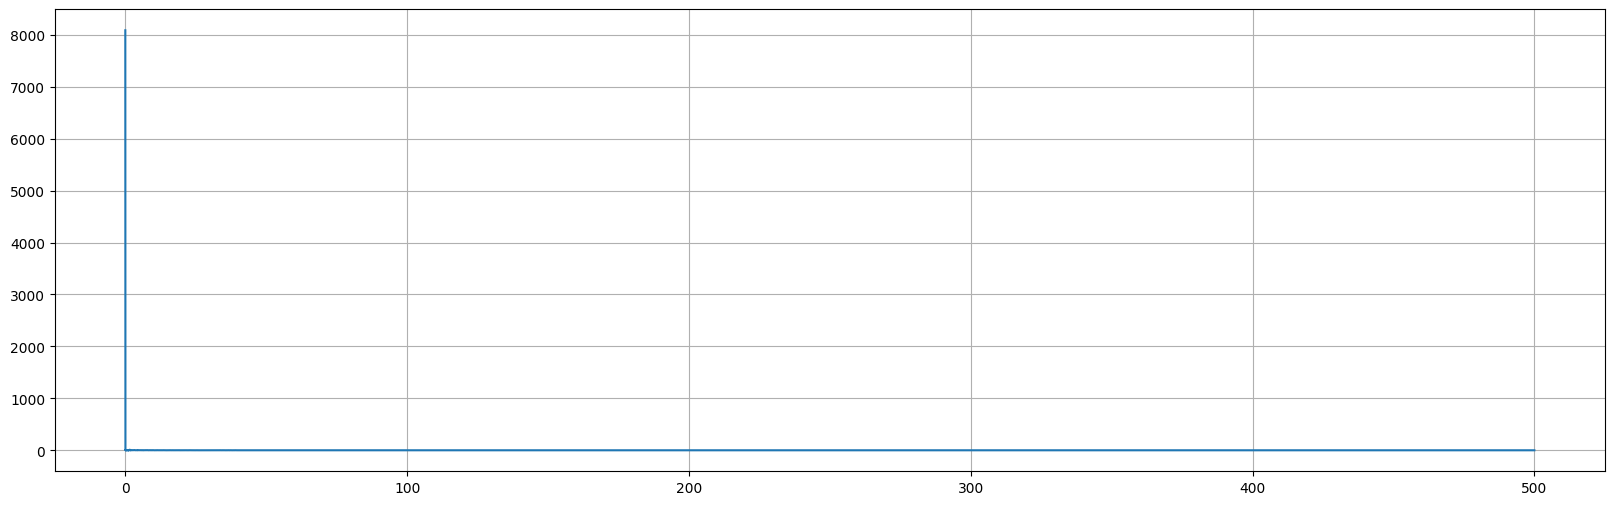

In [25]:
N = len(test[0,...])
T = 1.0 / sampling_rate
yf = fft(test[0,...])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

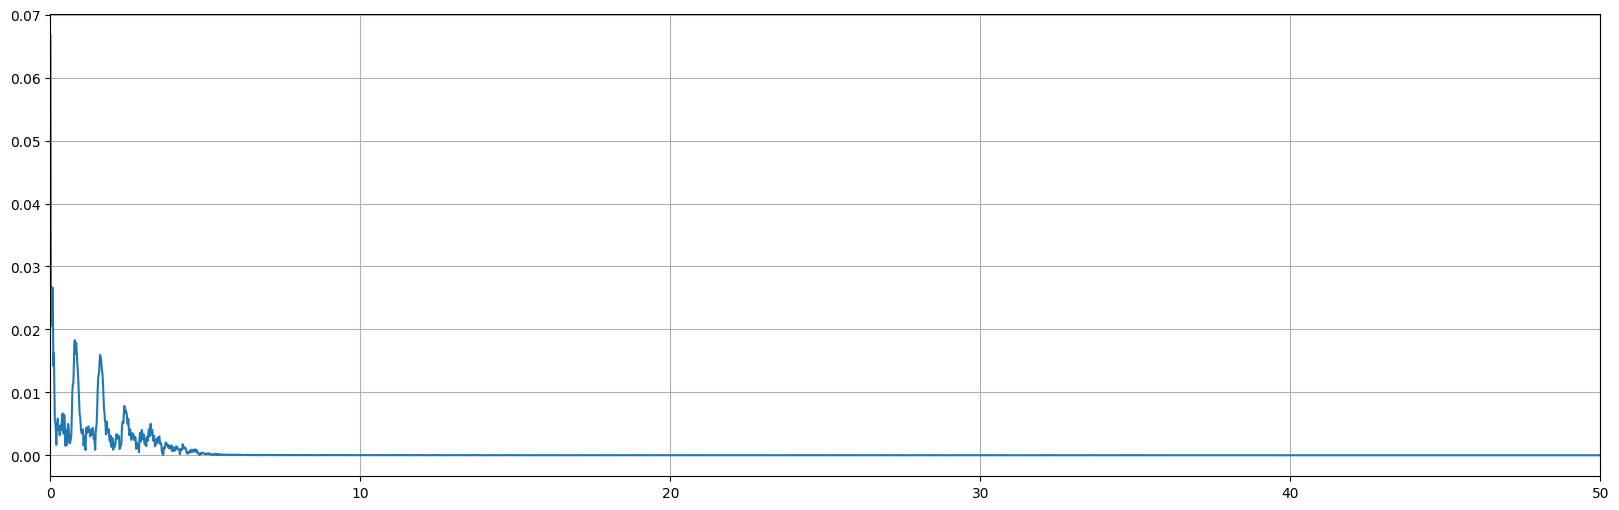

In [26]:
N = len(data2[0,...])
T = 1.0 / sampling_rate
yf = fft(data2[0,...])
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 50)
plt.grid()